# VaR Backtesting of Simulated Stock Prices
### Billy Ford
## Introduction
In this notebook we demonstrate some of the basic concepts behind traded risk modelling, by performing a Monte-Carlo simulation of Googles stock price, measure the Value-at-Risk, and finally backtesting our model.

## Geometric Brownian motion
We model the stock price $S_t$ using a Geometric Brownian Motion process, which takes the form:

$$ dS_t = \mu S_t dt + \sigma S_t dW_t, $$

where $\mu$ is the model drift, $\sigma$ is the volatility, and $dW$ represents a Wiener process which encodes the stochastic fluctuation of the stock price. The solution for the time evolution of $S$ is given by:

$$ S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right) t - \sigma W_t \right). $$

## Preliminaries
We begin by loading in the classes and functions defined to contain the data and models, as well as for performing the risk calculations and backtesting. We also define the parameters for our calibration and simulation, as well as specifying the stock we wish to simulate.

In [1]:
from stock_classes import *
from risk_calculations import *
from backtest_functions import *
pd.options.mode.chained_assignment = None

In [2]:
# Set calibrations and simulation params
stock_name = "GOOG"
calibration_start_date = "01/01/2015"
calibration_end_date = "31/12/2020"
sim_start_date = "01/01/2021"
sim_end_date = "01/12/2021"
npaths = 1000

## A Glimpse at the Data
First let us plot the historical time series to be used to calibrate the GBM model. We can see the steady and then more dramatic rise in the 5 year calibration period. We should therefore expect to observe an positive drift in the model calibration process. 

We can also look at the daily returns of the stock price. We observe the returns resemble a normal distribution around zero. As a sanity check, we can sum the returns to confirm the total is the difference between the current price and intial price on the calibration start date.

[*********************100%***********************]  1 of 1 completed


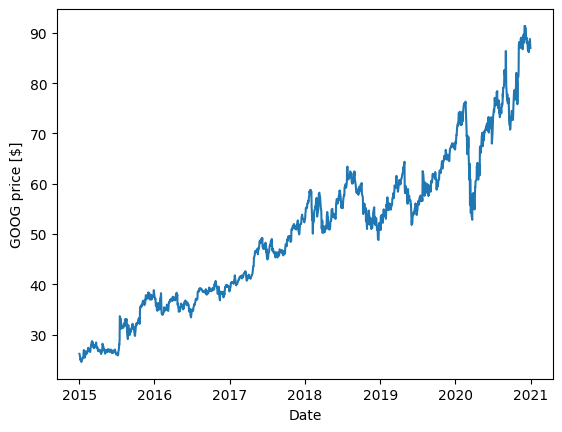

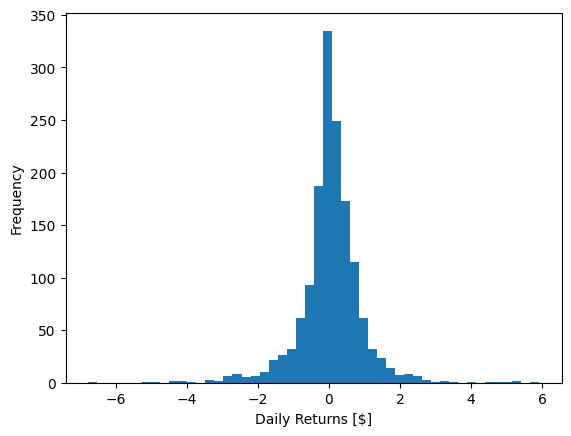

Total returns: 60.80734443664551
Final price - Start price: 60.80734443664551


In [3]:
# Read and plot google stock data
google_data = StockData(stock_name)
google_data.get_data(calibration_start_date, calibration_end_date)
google_data.timeseries_plot()
google_data.returns_plot()

# Sum daily returns
tot_returns = google_data.data["Returns"].sum()
price_diff = google_data.data["Adj Close"][-1] - google_data.data["Adj Close"][0]
print("Total returns: "+str(tot_returns))
print("Final price - Start price: "+str(price_diff))

## Calibrating the Model
In this step we use historical data to calibrate the GBM model. This is simply a way of extracting the drift and volatility model parameters for the GBM simulation, $\mu$ and $\sigma$. To do this, we start with the daily absolute returns, and convert to a log returns:

$$ R^{\text{log}}_{t} = \log \left(1 + \frac{R^{\text{abs}}_t}{ R^{\text{abs}}_{t-1}}\right).$$

We compute the mean ($\mu$) and standard deviation ($\sigma$) of this distribution, and then set the simulation model parameters for drift and volatility as $\left(\mu - \frac{\sigma^2}{2} \right)$ and $\sigma$ respectively.

We can take a look at the string representation of the model object, showing now that calibration has been performed using the data we plotted earlier, and the calibration parameters obtained. However there is one last step, to simulate the model.

In [4]:
# Initialise model and calibrate parameters using historical data
google_model = StockModel(stock_name)
google_model.calibrate(calibration_start_date, calibration_end_date)
print(google_model)

[*********************100%***********************]  1 of 1 completed
Stock name: GOOG
Model calibrated using data for 01/01/2015 to 31/12/2020
Model parameters mu: 0.0006530744037578386, sigma: 0.016903446881352608
Model not simulated.


## Simulating the Model
Finally, we take the calibrated model and perform and a Monte Carlo simulation to observe the projected returns across a number of simulated paths. Starting with a day on which we can observe the price, which we refer to as $S_0$, the price on the next day will be:

$$ S_t = S_0 e^{\mu + \sigma W_t},$$

where $W_t$ is a draw from a Wiener process. As we can see, the returns for a given day therefore depend on the price the previous day. Generally when simulating stock prices, we hope to generate a large number of paths (~$10^5$), and so generating can lead to some computational burden.

Rather than explicitely looping over all days and all paths, we can generate our grid of random numbers all in one go, in an array of dimension $npaths \times ndays$. Initialising all paths with the value of $S_0$, we can loop over the number of days in the simulation, updating all paths at the same time for each day.

Simulating 1000 paths, we can see the projections. In particular, we notice that more paths lead to an increased stock price, which is expected given we calibrate the model on data from a period where the price increased, and hence yielded a positive drift.

As a final sanity check, we can see the string representation of the model now shows as simulated.

[*********************100%***********************]  1 of 1 completed


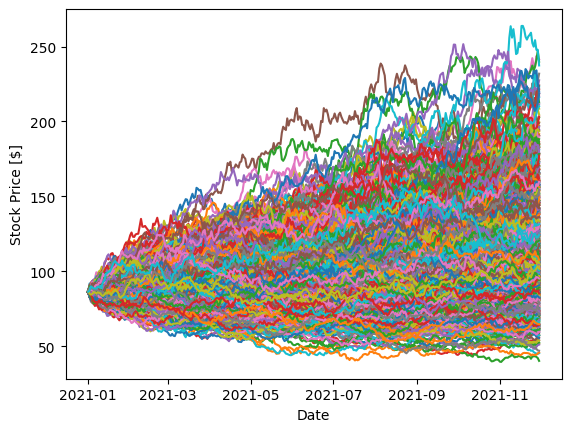

Stock name: GOOG
Model calibrated using data for 01/01/2015 to 31/12/2020
Model parameters mu: 0.0006530744037578386, sigma: 0.016903446881352608
Model simulated between dates 01/01/2021 to 01/12/2021


In [5]:
# Simulate stock price
google_model.simulate(sim_start_date, sim_end_date, npaths)
google_model.plot_paths()
print(google_model)

## Value-at-Risk
In this next section we use make use of the risk_calculations.py, to compute various risk measures. The most common is Value-at-Risk, which is simply a measure of the $p\%$ percentile of the distribution of projected PnL over an $n$-day period. A common measure is the $99\%$ 10-day VaR, used to compute capital requirements under the Basel framework. While one can indeed directly measure the PnL over an arbitrary $n$-day horizon, it is commonplace to simply measure the 1-day VaR and use the assumption

$$ VaR_{n-\text{day}} \simeq VaR_{1-\text{day}} \times \sqrt{n}.$$

We set up our VaR parameters as follows.

In [6]:
# Set VaR parameters
var_start_date = "01/01/2020"
var_end_date = "01/01/2022"
horizon = 10
percentile = 95

In [7]:
# Grab data and compute VaR
var_data = grab_hist_data(stock_name, var_start_date, var_end_date)
var = var(stock_name, var_start_date, var_end_date, horizon, percentile)
print(str(horizon)+"-day VaR value: "+str(var))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
10-day VaR value: -9.015581905883778


## Expected shortfall
There are a number of drawbacks in VaR, for example it does not encod information on what lies beyond the tail, only where the tail is. It is also not additive, so can be difficult to aggregate across trades in a portfolio. Indeed with this in mind, new banking regulations known as the fundamental review of the trading book (FRTB) are being introduced, in which VaR is replaced with a new metric - expected shortfall (ES).

ES is similar to VaR, it is a percentile calculation applied to a returns distribution, however instead of simnoly measuring the percentile, ES is calculated by averaging the returns beyond the specified percentile $p$,

$$ ES_p = -\frac{1}{p} \int_0^p VaR_\gamma d\gamma. $$

We compute the ES below.

In [8]:
# Compute expected shortfall
es = expected_shortfall(stock_name, var_start_date, var_end_date, horizon, percentile)
print(str(horizon)+"-day ES value: "+str(es))

[*********************100%***********************]  1 of 1 completed
10-day ES value: -12.107263519706398


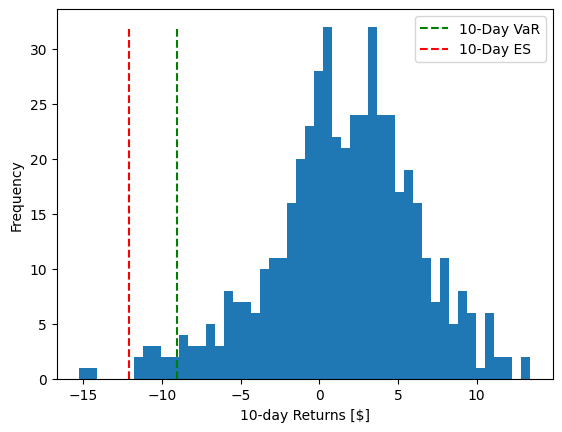

True

In [9]:
# Plot returns distribution with VaR
plot_returns(var_data, horizon, var, es)

## Backtesting
So far we used a model to simulate a stock price, and we have seen some of the risk calculations one can perform to quantify the risk of a portfolio. Next, we look at backtesting (BT), which is a way of assessing the risk model.

By using historical data, we can measure how often the actual daily returns exceed our worst-case estimate (i.e. VaR or ES), and count the number of times the actual returns exceed this estimate, a.k.a a BT exception. 

As a demonstration, we perform backtest on the historical VaR for google's stock price. To do so, we count the number of VaR backtesting exceptions, which are defined where the actual realised (negative) returns exceeds the VaR estimate. We use a one year VaR window, and backtest over a two year period between January 2020 to January 2022.

In [10]:
# Define backtest parameters
bt_start_date = "01/01/2020"
bt_end_date = "01/01/2022"
n_years = 1
percentile = 95

In [11]:
# Count number of exceptions
n_observations = ((pd.to_datetime(bt_end_date, format='%d/%m/%Y')\
                                     - pd.to_datetime(bt_start_date, format='%d/%m/%Y')).days)
n_exceptions = var_exceptions_count(stock_name, bt_start_date, bt_end_date, n_years, percentile)
print("Number of observations: "+str(n_observations))
print("Number of exceptions: "+str(n_exceptions))

[*********************100%***********************]  1 of 1 completed
Number of observations: 731
Number of exceptions: 26


## Interpreting the exception count
We have created a simple historical simulation VaR model to estimate the one day 95% tail loss, and counted how often this estimate is breached. But how do we make sense of this result? This is where statistical testing enters.

In market risk, as we are projecting daily returns, each daily return is an independent observation, with a fixed probability of an exception occuring. We would therefore expect the number of exceptions to follow a binomial distribution, similar to fipping a coin. For $n$ trial of a process with two outcomes with probabilities $p$ and $1 = 1-p$, the probability of $x$ outcomes is: 

$$ P_x = \begin{pmatrix} n \\ x \end{pmatrix} p^x q^{n-x}.$$

In our example using two years of data, we have 731 independent observations, and under the assumption that our VaR model is suitable, we therefore have a 5% probability each day of an exception (using the 95% VaR). Using the above, we can therefore construct a distribution of the probability of obtaining $x$ backtesting exceptions. 

The corresponding p-value for the model represents the probability of obtaining a test result (number of exceptions) at least as extreme than the value observed. This is obtained by evaluating the observed number of exceptions against the cumulative distribution function of the binomial distribution. 

In other words, if we say our null hypothesis is that the model used to compute a VaR value is an appropriate model that matches the real-life stock moves, the $p$-value gives the probability of accepting the null hypothesis.

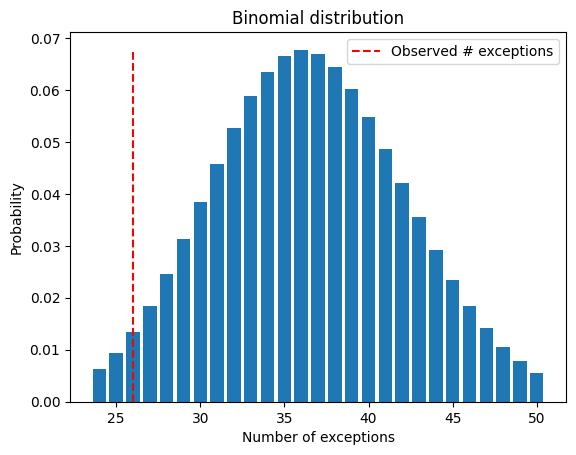

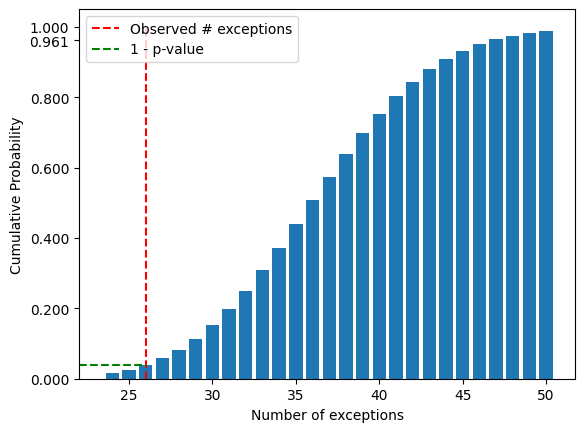

p-Value: 0.9610255667296155


In [12]:
# Compute binomial distribution and generate p-value
p_value = compute_p_value(n_observations, n_exceptions, float(1-percentile/100), plots=True)
print("p-Value: "+str(p_value))

We observe a large $p$-value, as the observed number of backtesting exceptions falls far to the left of the CDF (which corresponds to $1 - p\text{-value}$). This indicates that the observed number of backtesting exceptions is not an extreme result, and that we accept our null hypothesis that the historical simulation model using a rolling two year window of time series data is an appropriate estimator of the 95$%$ 1-day VaR.